# PPO, R-PPO and VAE comparison

## Frauds in the dataset
We compute how much money a fraudster is able to collect with a card in the simulator.

from parameters import CardSimParameters, Parameters

params = Parameters(cardsim=CardSimParameters.paper_params())
env = params.create_env()
banksys = env.system

## Score over training time

In [1]:
import numpy as np

anomaly = True

if anomaly:
    logdirs = {
        "Mimicry": "logs/anomaly/vae/2025-09-19T15-46-05.846486",
        "FRAUD-RLA": "logs/anomaly/ppo/2025-09-19T09-43-04.501028",
        "R-FRAUD-RLA": "logs/anomaly/rppo/2025-09-19T13-05-17.374379",
    }
else:
    logdirs = {
        "Mimicry": "logs/no-anomaly/no-anomaly/vae/2025-09-19T16-41-07.764246",
        "FRAUD-RLA": "logs/no-anomaly/no-anomaly/ppo/2025-09-19T11-40-32.971413",
        "R-FRAUD-RLA": "logs/no-anomaly/no-anomaly/rppo/2025-09-19T14-08-14.120200"
    }

    
print(logdirs)

def moving_average(data, window_size=100):
    """Compute the moving average of a 1D array."""
    return np.convolve(data, np.ones(window_size) / window_size, mode="valid")


{'Mimicry': 'logs/anomaly/vae/2025-09-19T15-46-05.846486', 'FRAUD-RLA': 'logs/anomaly/ppo/2025-09-19T09-43-04.501028', 'R-FRAUD-RLA': 'logs/anomaly/rppo/2025-09-19T13-05-17.374379'}


In [2]:
import os
from plots import Experiment

from parameters import Parameters, serialize_unknown





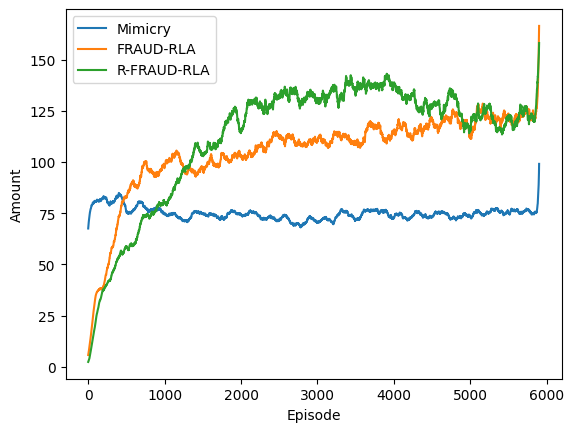

In [3]:
import matplotlib.pyplot as plt
from plots import Experiment

PLOT_SUM = False
import numpy as np
import matplotlib.pyplot as plt

# First, collect all sequences to determine the max length
all_means = {}
all_stds = {}
all_sums = {}
max_len = 2500

# First pass to find max length
for label, logdir in logdirs.items():
    exp = Experiment.load(logdir)
    mean, std = exp.mean_std_amounts_over_time
    mean = moving_average(mean)
    summa = np.cumsum(mean)
    std = moving_average(std)
    all_means[label] = mean
    all_sums[label] = summa
    all_stds[label] = std
    max_len = max(max_len, len(mean))

# Now pad all sequences to max_len with NaNs
for label in logdirs:
    mean = all_means[label]
    summa = all_sums[label]
    std = all_stds[label]
    padded_mean = np.full(max_len, np.nan)
    padded_sum = np.full(max_len, np.nan)
    padded_std = np.full(max_len, np.nan)
    padded_mean[:len(mean)] = mean
    padded_sum[:len(summa)] = summa
    padded_std[:len(std)] = std


    # Compute 95% CI
    # ci95 = 1.96 * (padded_std / exp.n_runs**0.5)
    x = np.arange(max_len)
    if PLOT_SUM:
        plt.plot(x, padded_sum, label=label)
    else:
        plt.plot(x, padded_mean, label=label)
    #plt.fill_between(x, padded_mean - ci95, padded_mean + ci95, alpha=0.5)

plt.xlabel("Episode")
plt.ylabel("Amount")
#plt.ylim(top=300)
plt.legend()
#plt.show()
plt.savefig("amount-over-time_anomaly.svg")



In [4]:
import numpy as np
import pandas as pd

# Dictionary to store results
results = {
    "Label": [],
    "Episodes": [],
    "Mean": [],
    #"Variance": []
}

for label, logdir in logdirs.items():
    print(logdir)
    exp = Experiment.load(logdir)
    print(f"There are {exp.n_runs} runs in {label}")
    amounts = exp.amounts_over_time  # shape: (n_runs, n_episodes)

    for episodes in [1000, 2000, 4000]:
        if amounts.shape[1] >= episodes:
            cumulated = np.sum(amounts[:, :episodes], axis=1)
            mean = int(np.mean(cumulated))
            var = np.round(np.var(cumulated, ddof=1), 2)  # sample variance

            results["Label"].append(label)
            results["Episodes"].append(episodes)
            results["Mean"].append(mean)
            #results["Variance"].append(var)
        else:
            print(f"{label} has fewer than {episodes} episodes. Skipping.")

        

# Convert to DataFrame for pretty printing or export
results_df = pd.DataFrame(results)
results_df


logs/anomaly/vae/2025-09-19T15-46-05.846486
There are 32 runs in Mimicry
logs/anomaly/ppo/2025-09-19T09-43-04.501028
There are 32 runs in FRAUD-RLA
logs/anomaly/rppo/2025-09-19T13-05-17.374379
There are 32 runs in R-FRAUD-RLA


,Label,Episodes,Mean
0,Mimicry,1000,78121
1,Mimicry,2000,152090
2,Mimicry,4000,298650
3,FRAUD-RLA,1000,66791
4,FRAUD-RLA,2000,166120
5,FRAUD-RLA,4000,386770
6,R-FRAUD-RLA,1000,50146
7,R-FRAUD-RLA,2000,152757
8,R-FRAUD-RLA,4000,417154


logs/anomaly/vae/2025-09-19T15-46-05.846486
There are 32 runs in Mimicry
logs/anomaly/ppo/2025-09-19T09-43-04.501028
There are 32 runs in FRAUD-RLA
logs/anomaly/rppo/2025-09-19T13-05-17.374379
There are 32 runs in R-FRAUD-RLA
         Label  Episodes    Mean
0      Mimicry      1000   78121
1      Mimicry      2000  152090
2      Mimicry      4000  298650
3    FRAUD-RLA      1000   66791
4    FRAUD-RLA      2000  166120
5    FRAUD-RLA      4000  386770
6  R-FRAUD-RLA      1000   50146
7  R-FRAUD-RLA      2000  152757
8  R-FRAUD-RLA      4000  417154


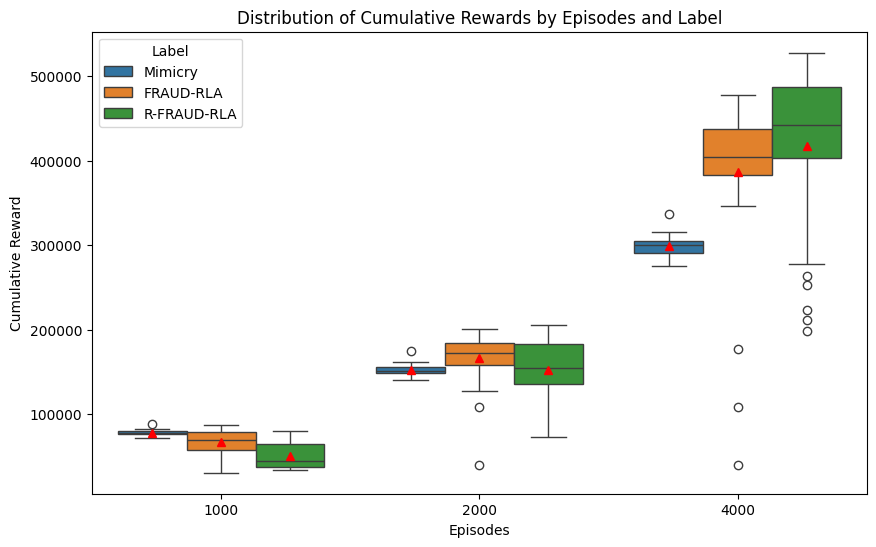

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dictionary to store results
results = {
    "Label": [],
    "Episodes": [],
    "Mean": [],
    #"Variance": []
}

# Long-form storage for boxplots
all_values = {
    "Label": [],
    "Episodes": [],
    "Value": []
}

for label, logdir in logdirs.items():
    print(logdir)
    exp = Experiment.load(logdir)
    print(f"There are {exp.n_runs} runs in {label}")
    amounts = exp.amounts_over_time  # shape: (n_runs, n_episodes)

    for episodes in [1000, 2000, 4000]:
        if amounts.shape[1] >= episodes:
            cumulated = np.sum(amounts[:, :episodes], axis=1)
            mean = int(np.mean(cumulated))
            var = np.round(np.var(cumulated, ddof=1), 2)  # sample variance

            # Store summary stats
            results["Label"].append(label)
            results["Episodes"].append(episodes)
            results["Mean"].append(mean)
            #results["Variance"].append(var)

            # Store all values for plotting
            all_values["Label"].extend([label] * len(cumulated))
            all_values["Episodes"].extend([episodes] * len(cumulated))
            all_values["Value"].extend(cumulated.tolist())
        else:
            print(f"{label} has fewer than {episodes} episodes. Skipping.")

# Convert to DataFrames
results_df = pd.DataFrame(results)
all_values_df = pd.DataFrame(all_values)

print(results_df)

# --- Plot boxplots ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=all_values_df, x="Episodes", y="Value", hue="Label", showmeans=True, 
            showfliers=True, meanprops={"markerfacecolor": "red", "markeredgecolor": "red"},)
plt.title("Distribution of Cumulative Rewards by Episodes and Label")
plt.ylabel("Cumulative Reward")
plt.xlabel("Episodes")
plt.legend(title="Label")
#plt.show()
plt.savefig('Final_boxplots.svg')

In [6]:

table_df = pd.DataFrame()

for length in (1000, 2000, 4000):
    for label in ['Mimicry', 'FRAUD-RLA', 'R-FRAUD-RLA']:
        # Select the row in results_df where Episodes == length and Label == label
        value = results_df.loc[
            (results_df['Episodes'] == length) & (results_df['Label'] == label),
            'Mean'
        ].values[0]  # take the scalar

        # Assign it to your new table_df
        table_df.loc[label, length] = value
table_df

,1000,2000,4000
Mimicry,78121.0,152090.0,298650.0
FRAUD-RLA,66791.0,166120.0,386770.0
R-FRAUD-RLA,50146.0,152757.0,417154.0


## Number of transactions per card over time

import matplotlib.pyplot as plt
from plots import Experiment


for label, logdir in logdirs.items():
    exp = Experiment.load(logdir)
    print(f"There are {exp.n_runs} runs in {label}")
    data = exp.n_transactions_over_time
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    mean = moving_average(mean, window_size=100)[:-20]
    std = moving_average(std, window_size=100)[:-20]
    # Compute the 95% confidence interval from the STD
    ci95 = 1.96 * (std / exp.n_runs**0.5)
    plt.plot(mean, label=label)
    plt.fill_between(range(len(mean)), mean - ci95, mean + ci95, alpha=0.5)

plt.xlabel("Episode")
plt.ylabel("Number of transactions per card")
plt.legend()
plt.savefig("n-transactions.svg")

experiment = Experiment.load(logdir)
label, max(experiment.n_transactions_over_time[0])

In [7]:
exp.total_amounts

array([792214.92964935, 772211.26090673, 724412.42071709, 749927.8606157 ,
       651406.0200206 , 797147.61888772, 828504.57987818, 765773.09006086,
       671829.87974319, 418239.67005149, 686026.69952378, 541722.91996485,
       678571.47986884, 764664.77072006, 842465.44931239, 736302.33931625,
       685318.39009146, 230351.86000962, 516249.37972698, 642360.65940933,
       590162.82967339, 798141.99976383, 385897.31979866, 730938.91965373,
       725009.07999638, 714787.44018902, 648691.67972198, 638929.94016805,
       726967.08062508, 678064.65036142, 652993.43952237, 694981.31971419])

## Total amount collected

/tmp/ipykernel_102336/2554115465.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(amounts, labels=labels, showmeans=True)


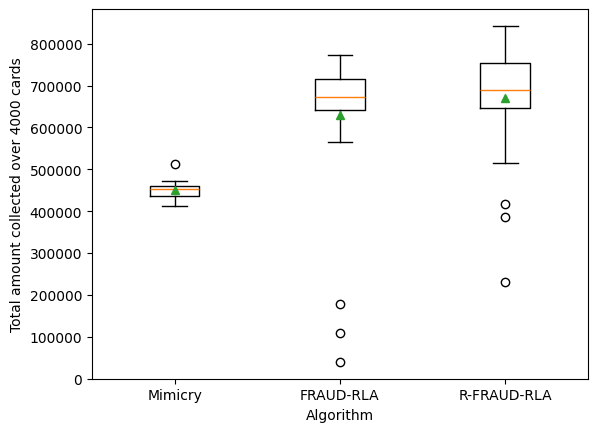

In [8]:
import matplotlib.pyplot as plt
from plots import Experiment

amounts = []
labels = []
for label, logdir in logdirs.items():
    exp = Experiment.load(logdir)
    amounts.append(exp.total_amounts)
    labels.append(label)

plt.boxplot(amounts, labels=labels, showmeans=True)
plt.ylabel("Total amount collected over 4000 cards")
plt.xlabel("Algorithm")
#plt.grid(axis="y")
plt.ylim(bottom=0)  #0  1_000_000
plt.savefig("boxplot-amounts_Anomaly.svg")
plt.show()


## Statistical Tests 

In [9]:
# Get the data


# Dictionary to store results
results = {
    "Label": [],
    "Episodes": [],
    "Mean": [],
    #"Variance": []
}

# Long-form storage for boxplots
all_values = {
    "Label": [],
    "Episodes": [],
    "Value": []
}

for label, logdir in logdirs.items():
    print(logdir)
    exp = Experiment.load(logdir)
    print(f"There are {exp.n_runs} runs in {label}")
    amounts = exp.amounts_over_time  # shape: (n_runs, n_episodes)

    for episodes in [1000, 2000, 4000]:
        if amounts.shape[1] >= episodes:
            cumulated = np.sum(amounts[:, :episodes], axis=1)
            mean = int(np.mean(cumulated))
            var = np.round(np.var(cumulated, ddof=1), 2)  # sample variance

            # Store summary stats
            results["Label"].append(label)
            results["Episodes"].append(episodes)
            results["Mean"].append(mean)
            #results["Variance"].append(var)

            # Store all values for plotting
            all_values["Label"].extend([label] * len(cumulated))
            all_values["Episodes"].extend([episodes] * len(cumulated))
            all_values["Value"].extend(cumulated.tolist())
        else:
            print(f"{label} has fewer than {episodes} episodes. Skipping.")

# Convert to DataFrames
results_df = pd.DataFrame(results)
all_values_df = pd.DataFrame(all_values)

all_values_df



logs/anomaly/vae/2025-09-19T15-46-05.846486
There are 32 runs in Mimicry
logs/anomaly/ppo/2025-09-19T09-43-04.501028
There are 32 runs in FRAUD-RLA
logs/anomaly/rppo/2025-09-19T13-05-17.374379
There are 32 runs in R-FRAUD-RLA


,Label,Episodes,Value
0,Mimicry,1000,76463.009882
1,Mimicry,1000,76222.470051
2,Mimicry,1000,80165.830101
3,Mimicry,1000,73383.899925
4,Mimicry,1000,77958.270149
...,...,...,...
283,R-FRAUD-RLA,4000,385886.580061
284,R-FRAUD-RLA,4000,488095.500425
285,R-FRAUD-RLA,4000,439337.040620
286,R-FRAUD-RLA,4000,411045.269494


In [10]:
from cd_diagram import graph_ranks, form_cliques, draw_cd_diagram, wilcoxon_holm


In [11]:
all_values_1000 = all_values_df.loc[all_values_df['Episodes']== 1000, :]
all_values_2000 = all_values_df.loc[all_values_df['Episodes']== 2000, :]
all_values_4000 = all_values_df.loc[all_values_df['Episodes']== 4000, :]

all_values_1000.drop(['Episodes'], axis=1, inplace=True)
all_values_2000.drop(['Episodes'], axis=1, inplace=True)
all_values_4000.drop(['Episodes'], axis=1, inplace=True)

/tmp/ipykernel_102336/3228915773.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_values_1000.drop(['Episodes'], axis=1, inplace=True)
/tmp/ipykernel_102336/3228915773.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_values_2000.drop(['Episodes'], axis=1, inplace=True)
/tmp/ipykernel_102336/3228915773.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_values_4000.drop(['Episodes'], axis=1, inplace=True)


In [12]:
all_values_1000['run'] = 3 * list(range(int(all_values_1000.shape[0]/3)))
all_values_2000['run'] = 3 * list(range(int(all_values_2000.shape[0]/3)))
all_values_4000['run'] = 3 * list(range(int(all_values_4000.shape[0]/3)))

all_values_1000.head()

/tmp/ipykernel_102336/195112772.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_values_1000['run'] = 3 * list(range(int(all_values_1000.shape[0]/3)))
/tmp/ipykernel_102336/195112772.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_values_2000['run'] = 3 * list(range(int(all_values_2000.shape[0]/3)))
/tmp/ipykernel_102336/195112772.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

,Label,Value,run
0,Mimicry,76463.009882,0
1,Mimicry,76222.470051,1
2,Mimicry,80165.830101,2
3,Mimicry,73383.899925,3
4,Mimicry,77958.270149,4


In [13]:
all_values_1000.rename( {'Label': 'classifier_name', 'run': 'dataset_name', 'Value': 'accuracy'}, axis=1, inplace=True)
all_values_2000.rename( {'Label': 'classifier_name', 'run': 'dataset_name', 'Value': 'accuracy'}, axis=1, inplace=True)
all_values_4000.rename( {'Label': 'classifier_name', 'run': 'dataset_name', 'Value': 'accuracy'}, axis=1,inplace=True) 

/tmp/ipykernel_102336/50837026.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_values_1000.rename( {'Label': 'classifier_name', 'run': 'dataset_name', 'Value': 'accuracy'}, axis=1, inplace=True)
/tmp/ipykernel_102336/50837026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_values_2000.rename( {'Label': 'classifier_name', 'run': 'dataset_name', 'Value': 'accuracy'}, axis=1, inplace=True)
/tmp/ipykernel_102336/50837026.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [14]:
all_values_1000

all_values_1000['classifier_name'] = all_values_1000['classifier_name'].replace({'VAE': 'Mimicry', 'PPO': 'FRAUD-RLA', 'R-PPO': 'R-FRAUD-RLA'})
all_values_2000['classifier_name'] = all_values_2000['classifier_name'].replace({'VAE': 'Mimicry', 'PPO': 'FRAUD-RLA', 'R-PPO': 'R-FRAUD-RLA'})
all_values_4000['classifier_name'] = all_values_4000['classifier_name'].replace({'VAE': 'Mimicry', 'PPO': 'FRAUD-RLA', 'R-PPO': 'R-FRAUD-RLA'})

/tmp/ipykernel_102336/418997765.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_values_1000['classifier_name'] = all_values_1000['classifier_name'].replace({'VAE': 'Mimicry', 'PPO': 'FRAUD-RLA', 'R-PPO': 'R-FRAUD-RLA'})
/tmp/ipykernel_102336/418997765.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_values_2000['classifier_name'] = all_values_2000['classifier_name'].replace({'VAE': 'Mimicry', 'PPO': 'FRAUD-RLA', 'R-PPO': 'R-FRAUD-RLA'})
/tmp/ipykernel_102336/418997765.py:5: SettingWithCopyWar

In [15]:
all_values_1000.loc[all_values_1000['dataset_name']==95]

,classifier_name,accuracy,dataset_name


In [16]:
draw_cd_diagram(df_perf=all_values_4000, title='Total compromised amount after 4000 rounds', labels=True, file_name='cd-diagram-4000.png')


['Mimicry' 'FRAUD-RLA' 'R-FRAUD-RLA']
FRAUD-RLA      10.0
Mimicry         0.0
R-FRAUD-RLA    22.0
dtype: float64
Mimicry        2.71875
FRAUD-RLA      1.78125
R-FRAUD-RLA    1.50000
dtype: float64
('Mimicry', 'R-FRAUD-RLA', np.float64(2.4959444999694824e-07), True)
('FRAUD-RLA', 'Mimicry', np.float64(0.0001777801662683487), True)
('FRAUD-RLA', 'R-FRAUD-RLA', np.float64(0.13863924238830805), False)
Index(['Mimicry', 'FRAUD-RLA', 'R-FRAUD-RLA'], dtype='object')
[1, 2]
